#imports

In [5]:
import pandas as pd
import numpy as np

# Imports for model building
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout

# Imports for image transformations
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomTranslation

# Imports for using a pre-trained model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# Importing Keras utility for image dataset loading
from keras.utils import image_dataset_from_directory

# Imports for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from tensorflow.keras.applications.vgg16 import preprocess_input


#Extract vgg16 features for train set 

In [1]:
import numpy as np
import cv2
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

# Load grayscale arrays
X_gray = np.load('/content/drive/MyDrive/X_traindl_without_masks.npy')  # shape: (N, H, W, 1)

# Ensure X_gray has shape (N, H, W)
if X_gray.ndim == 4 and X_gray.shape[-1] == 1:
    X_gray = np.squeeze(X_gray, axis=-1)

vgg = VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))

batch_size = 32
vgg_feats = []

for start in range(0, len(X_gray), batch_size):
    end = min(start + batch_size, len(X_gray))
    batch_gray = X_gray[start:end]

    batch_rgb = np.zeros((len(batch_gray), 224, 224, 3), dtype='float32')
    for i, img in enumerate(batch_gray):
        resized = cv2.resize(img, (224, 224))
        batch_rgb[i] = cv2.cvtColor(resized, cv2.COLOR_GRAY2BGR)

    batch_pre = preprocess_input(batch_rgb)
    feats = vgg.predict(batch_pre, verbose=0)
    vgg_feats.append(feats)

vgg_feats = np.vstack(vgg_feats)  # shape: (N, 512)
np.save('/content/drive/MyDrive/X_vgg_feats.npy', vgg_feats)



# Extract vgg features for validation set 

In [5]:
import numpy as np
import cv2
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

def extract_vgg_features(X_gray):
    if X_gray.ndim == 4 and X_gray.shape[-1] == 1:
        X_gray = np.squeeze(X_gray, axis=-1)

    vgg = VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))

    batch_size = 32
    vgg_feats = []

    for start in range(0, len(X_gray), batch_size):
        end = min(start + batch_size, len(X_gray))
        batch_gray = X_gray[start:end]

        batch_rgb = np.zeros((len(batch_gray), 224, 224, 3), dtype='float32')
        for i, img in enumerate(batch_gray):
            resized = cv2.resize(img, (224, 224))
            batch_rgb[i] = cv2.cvtColor(resized, cv2.COLOR_GRAY2BGR)

        batch_pre = preprocess_input(batch_rgb)
        feats = vgg.predict(batch_pre, verbose=0)
        vgg_feats.append(feats)

    return np.vstack(vgg_feats)

# --- Load your data ---
X_val = np.load('/content/drive/MyDrive/X_valdl_without_masks.npy')

# --- Call the function ---
X_val_feats = extract_vgg_features(X_val)

# --- Optionally save to disk ---
np.save('/content/drive/MyDrive/X_val_vgg_feats.npy', X_val_feats)


#Extract vgg16 features for test


In [ ]:

# Load your test data
X_test = np.load('/content/drive/MyDrive/X_testdl_without_masks.npy')

# Extract VGG16 features for test set
X_test_feats = extract_vgg_features(X_test)

# Save the extracted test features (optional)
np.save('/content/drive/MyDrive/X_test_vgg_feats.npy', X_test_feats)



In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load pre-extracted VGG features (already shape (N, 512))
X_train = np.load('/content/drive/MyDrive/X_vgg_feats.npy')
y_train = np.load('/content/drive/MyDrive/y_traindl_without_masks.npy')

X_val   = np.load('/content/drive/MyDrive/X_val_vgg_feats.npy')
y_val   = np.load('/content/drive/MyDrive/y_valdl_without_masks.npy')

X_test  = np.load('/content/drive/MyDrive/X_test_vgg_feats.npy')
y_test  = np.load('/content/drive/MyDrive/y_testdl_without_masks.npy')


In [63]:
print(X_train.shape)  # should be (N, 512)
print(X_val.shape)    # should be (N, 512)
print(X_test.shape)   # if (N, H, W, C), you need to extract features first


(21852, 512)
(5463, 512)
(3176, 512)


#Build classifier

In [64]:
#Since we have already extracted VGG16 features separately, we didnt use the whole VGG16 base model again in our model
#Instead, we build a simple classifier model that takes the extracted VGG16 features as inpu
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Model (add BatchNorm to second Dense)
inputs = Input(shape=(512,))
x = Dense(256, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


#Train

In [65]:
history = model.fit(
    X_train, y_train,  # y_train is one-hot encoded
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=32,
    callbacks=[early_stop]
)



Epoch 1/25
683/683 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.3843 - loss: 1.6360 - val_accuracy: 0.6022 - val_loss: 1.0287
Epoch 2/25
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5278 - loss: 1.2389 - val_accuracy: 0.6374 - val_loss: 0.9317
Epoch 3/25
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5681 - loss: 1.0952 - val_accuracy: 0.6396 - val_loss: 0.8883
Epoch 4/25
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5835 - loss: 1.0318 - val_accuracy: 0.6509 - val_loss: 0.8534
Epoch 5/25
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6012 - loss: 0.9803 - val_accuracy: 0.6683 - val_loss: 0.8295
Epoch 6/25
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6064 - loss: 0.9493 - val_accuracy: 0.6647 - val_loss: 0.8208
Epoch 7/25
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6209 - loss: 0.9294 - val_accuracy: 0.6733 - val_loss: 0.8019
Epoch 8/25
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6245 - loss: 0.9044 - val_accuracy: 0.

#Evaluate

In [66]:

# --- Evaluate ---
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc:.4f}")



100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7925 - loss: 0.5730

Test Accuracy: 0.7406


#Accuracy plots

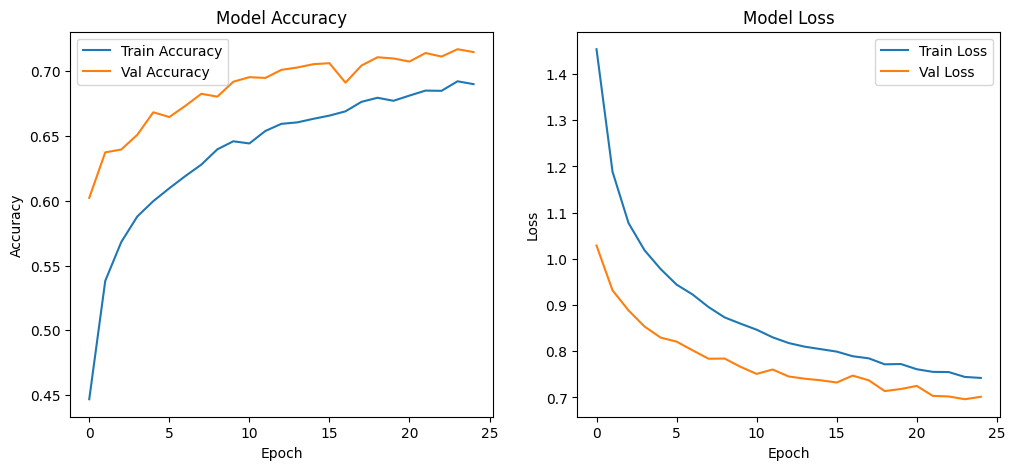

In [67]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Plot training & validation accuracy values
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


# Confusion matrix

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


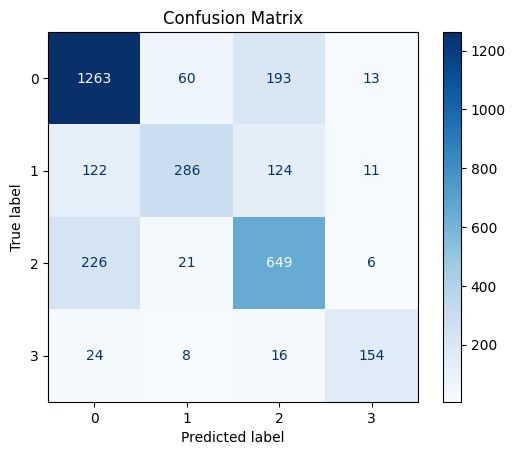

In [68]:
# Predict classes for test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


#Save model

In [77]:
# Save the model with a valid file extension
model.save('/content/drive/MyDrive/vgg16_model1.keras')

#Improved  Model

In [72]:
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

inputs = Input(shape=(512,))

x = Dense(512, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(4, activation='softmax')(x)

model2 = Model(inputs, outputs)
model2.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model2.summary()


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 430,980 (1.64 MB)

 Trainable params: 429,188 (1.64 MB)

 Non-trainable params: 1,792 (7.00 KB)

#Train

In [73]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/25
683/683 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5237 - loss: 1.2240 - val_accuracy: 0.6573 - val_loss: 0.8266 - learning_rate: 0.0010
Epoch 2/25
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6251 - loss: 0.8863 - val_accuracy: 0.6766 - val_loss: 0.7755 - learning_rate: 0.0010
Epoch 3/25
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6513 - loss: 0.8313 - val_accuracy: 0.6963 - val_loss: 0.7368 - learning_rate: 0.0010
Epoch 4/25
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6680 - loss: 0.7994 - val_accuracy: 0.6969 - val_loss: 0.7229 - learning_rate: 0.0010
Epoch 5/25
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6775 - loss: 0.7693 - val_accuracy: 0.7090 - val_loss: 0.7076 - learning_rate: 0.0010
Epoch 6/25
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6832 - loss: 0.7608 - val_accuracy: 0.7102 - val_loss: 0.7054 - learning_rate: 0.0010
Epoch 7/25
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6900 - loss: 0.7405 -

#Evaluate

In [74]:

# --- Evaluate ---
test_loss, test_acc = model2.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc:.4f}")


100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8182 - loss: 0.5028

Test Accuracy: 0.7733


#Plot epoch loss and accuracy

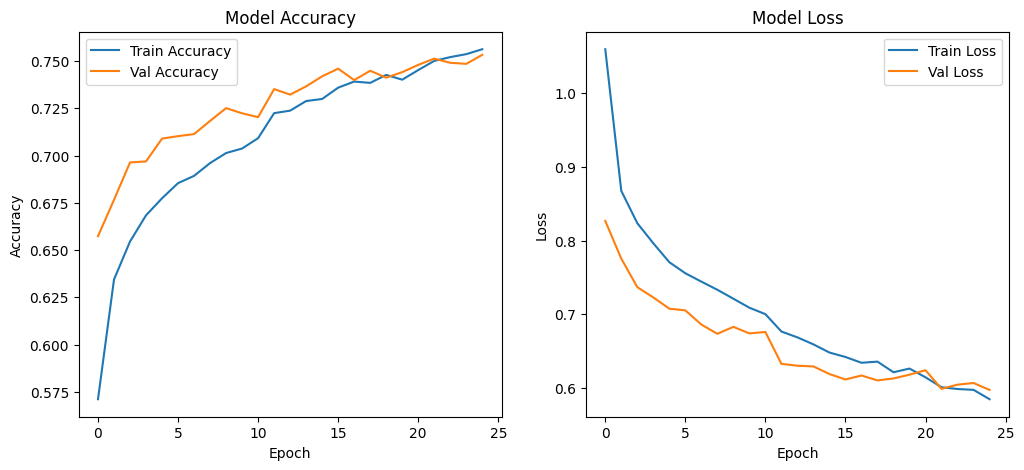

In [75]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Plot training & validation accuracy values
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# PLot confusion matrix

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


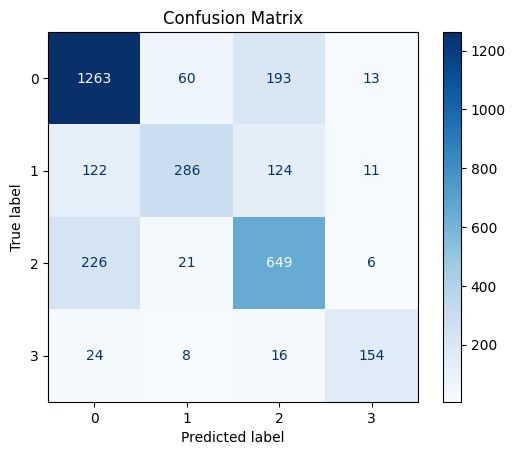

In [76]:
# Predict classes for test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

#Save model

In [78]:
# Save the model with a valid file extension
model.save('/content/drive/MyDrive/vgg16_model2.keras')